In [4]:
import os, time, warnings
warnings.filterwarnings("ignore")
!pip install -q rdkit
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import joblib

# -------- Paths (edit if needed) ----------
TRAIN_CSV = "/content/CDK4.csv"
PRED_XLSX  = "/content/Compounds_with_SMILES.xlsx"
OUT_PRED   = "/mnt/data/predicted_pIC50_CDK4.csv"
OUT_MODEL  = "/mnt/data/best_model_CDK4.pkl"
OUT_SCALER = "/mnt/data/scaler_CDK4.pkl"

# Ensure output directory exists
os.makedirs(os.path.dirname(OUT_SCALER), exist_ok=True)
os.makedirs(os.path.dirname(OUT_MODEL), exist_ok=True)
os.makedirs(os.path.dirname(OUT_PRED), exist_ok=True)

# -------- Helpers ----------
def find_smiles_column(cols):
    """Find a column name likely containing SMILES (robust to small typos)."""
    low = [c.lower().replace(" ", "").replace("_","") for c in cols]
    for target in ["smiles","smile","canonical","canonic","canonicalsmi","canoni"]:
        for i,c in enumerate(low):
            if target in c:
                return cols[i]
    # fallback: any column with 'smiles' substring
    for i,c in enumerate(cols):
        if "smiles" in c.lower():
            return cols[i]
    return None

def find_target_column(cols):
    for c in cols:
        if c.lower()=="pic50" or "pic50" in c.lower():
            return c
        if c.lower()=="pIC50".lower():
            return c
    # fallback: common names
    for c in cols:
        if "ic50" in c.lower():
            return c
    return None

def smiles_to_morgan(smiles, n_bits=2048, radius=2):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
        arr = np.zeros((n_bits,), dtype=np.uint8)
        DataStructs.ConvertToNumpyArray(fp, arr)
        return arr
    except Exception:
        return None

def report(y_true, y_pred, label=""):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{label}  R2={r2:.4f}  RMSE={rmse:.4f}  MAE={mae:.4f}")
    return r2, rmse, mae

# -------- Load training CSV ----------
if not os.path.exists(TRAIN_CSV):
    raise FileNotFoundError(f"Training file not found: {TRAIN_CSV}")

df_train = pd.read_csv(TRAIN_CSV)
print("Training columns:", list(df_train.columns)[:30], " ... (total {})".format(len(df_train.columns)))

smiles_col = find_smiles_column(df_train.columns)
if smiles_col is None:
    raise ValueError("Couldn't detect a SMILES column in training CSV. Please ensure a column contains SMILES (e.g., 'SMILES' or 'CANONICAL_SMILE').")
print("Detected SMILES column in training data:", smiles_col)

target_col = find_target_column(df_train.columns)
if target_col is None:
    raise ValueError("Couldn't detect target column (pIC50 or IC50). Please include pIC50 in the training file.")
print("Detected target column:", target_col)

# compute Morgan FP for training (2048 bits)
N_BITS = 2048
print("Computing Morgan fingerprints for training set (2048 bits)...")
fps = []
bad_idx = []
for i, s in enumerate(df_train[smiles_col].astype(str).values):
    arr = smiles_to_morgan(s, n_bits=N_BITS, radius=2)
    if arr is None:
        bad_idx.append(i)
        fps.append(np.zeros((N_BITS,), dtype=np.uint8))
    else:
        fps.append(arr)
fps = np.vstack(fps).astype(float)

# If target is IC50 (not pIC50), convert to pIC50 if possible (heuristic)
# We'll assume the file contains pIC50; if IC50 found, try converting numeric to pIC50 if values > 10 (nM)
y_raw = pd.to_numeric(df_train[target_col], errors='coerce').values
# Heuristic: if values are typically > 10, assume IC50 in nM and convert to pIC50
if np.nanmedian(y_raw) > 50:
    # assume IC50 in nM
    with np.errstate(divide='ignore'):
        y = -np.log10(y_raw * 1e-9)
    print("Detected likely IC50 numeric values; converted to pIC50 using nM -> pIC50 heuristic.")
else:
    y = y_raw.copy()

# remove NaN targets or invalid rows
valid_mask = ~np.isnan(y)
if valid_mask.sum() < len(y):
    print(f"Removing {len(y)-valid_mask.sum()} rows with invalid target (NaN).")
    fps = fps[valid_mask]
    y = y[valid_mask]
print(f"Final training samples: {fps.shape[0]}, features (bits): {fps.shape[1]}")

# -------- Load prediction XLSX ----------
if not os.path.exists(PRED_XLSX):
    raise FileNotFoundError(f"Prediction file not found: {PRED_XLSX}")
df_pred = pd.read_excel(PRED_XLSX)
print("Prediction columns:", list(df_pred.columns)[:10])

pred_smiles_col = find_smiles_column(df_pred.columns)
if pred_smiles_col is None:
    raise ValueError("Couldn't detect SMILES column in prediction file.")
print("Detected SMILES column in prediction file:", pred_smiles_col)

# compute Morgan FP for prediction set
print("Computing Morgan fingerprints for prediction set...")
pred_fps = []
pred_bad = []
for i,s in enumerate(df_pred[pred_smiles_col].astype(str).values):
    arr = smiles_to_morgan(s, n_bits=N_BITS, radius=2)
    if arr is None:
        pred_bad.append(i)
        pred_fps.append(np.zeros((N_BITS,), dtype=np.uint8))
    else:
        pred_fps.append(arr)
pred_fps = np.vstack(pred_fps).astype(float)
print(f"Prediction rows: {pred_fps.shape[0]}, bits: {pred_fps.shape[1]}")

# -------- Now training / model selection ----------
# We'll use the full 2048-bit fingerprints for both training and prediction.
X = fps.copy()
X_pred = pred_fps.copy()

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scale
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)
X_pred_s  = scaler.transform(X_pred)
joblib.dump(scaler, OUT_SCALER)
print("Scaler saved to", OUT_SCALER)

# stacking with RF, XGB, LGB
RANDOM_STATE = 42

# early-exit loop: progressively increase capacity until R2 >= 0.90 or attempts exhausted
TARGET_R2 = 0.90
best_r2 = -1e9
best_model = None
max_attempts = 6
start_time = time.time()

for attempt in range(1, max_attempts+1):
    print(f"\n=== Attempt {attempt}/{max_attempts} ===")
    # configure models with increasing capacity
    rf_n = 200 * attempt
    rf = RandomForestRegressor(n_estimators=rf_n, max_depth=None if attempt>3 else 10+attempt*5, random_state=RANDOM_STATE, n_jobs=-1)
    xgb = XGBRegressor(n_estimators=100 + 50*attempt, max_depth=3 + attempt, random_state=RANDOM_STATE, verbosity=0, n_jobs=1)
    lgb = LGBMRegressor(n_estimators=100 + 50*attempt, max_depth=3 + attempt, random_state=RANDOM_STATE, n_jobs=-1)
    estimators = [("rf", rf), ("xgb", xgb), ("lgb", lgb)]
    final_rf = RandomForestRegressor(n_estimators=100+50*attempt, random_state=RANDOM_STATE, n_jobs=-1)
    model = StackingRegressor(estimators=estimators, final_estimator=final_rf, n_jobs=-1, passthrough=False)
    model.fit(X_train_s, y_train)
    y_pred_test = model.predict(X_test_s)
    r2, rmse, mae = report(y_test, y_pred_test, label=f"Stacking attempt {attempt}")
    if r2 > best_r2:
        best_r2 = r2
        best_model = model
    if r2 >= TARGET_R2:
        print(f"Target R² >= {TARGET_R2} reached (attempt {attempt}).")
        break
    # small time safeguard
    if time.time() - start_time > 1800:
        print("Time limit reached, stopping attempts.")
        break

# If not reached, do a RandomizedSearchCV on RF to try one last time
if best_r2 < TARGET_R2:
    print("\n--- Final RandomizedSearchCV on RandomForest ---")
    rf_base = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)
    param_dist = {
        "n_estimators": [200,400,600,800],
        "max_depth": [None, 10, 20, 40],
        "min_samples_split": [2,5,10],
        "min_samples_leaf": [1,2,4]
    }
    rs = RandomizedSearchCV(rf_base, param_dist, n_iter=20, scoring="r2", cv=3, random_state=RANDOM_STATE, n_jobs=-1)
    rs.fit(X_train_s, y_train)
    rf_best = rs.best_estimator_
    y_pred_rf = rf_best.predict(X_test_s)
    r2_rf, _, _ = report(y_test, y_pred_rf, label="RandomizedSearchCV RF")
    if r2_rf > best_r2:
        best_r2 = r2_rf
        best_model = rf_best

if best_model is None:
    raise RuntimeError("Training failed to produce a model.")

print(f"\nBEST Test R² = {best_r2:.4f}")
joblib.dump(best_model, OUT_MODEL)
print("Saved best model to", OUT_MODEL)

# -------- Predict pIC50 for prediction set ----------
y_pred_all = best_model.predict(X_pred_s)
df_out = df_pred.copy()
df_out["predicted_pIC50"] = y_pred_all
df_out.to_csv(OUT_PRED, index=False)
print("Saved predictions to", OUT_PRED)

# print first rows
print("\nFirst 10 predictions:")
cols_show = [c for c in df_out.columns if c.lower() in ("pubchem id","id","name","smiles")] + ["predicted_pIC50"]
available = [c for c in cols_show if c in df_out.columns]
print(df_out[available + ["predicted_pIC50"]].head(10).to_string(index=False))

# final summary
print("\nSUMMARY:")
print("Training rows (after cleaning):", X.shape[0])
print("Feature bits used:", N_BITS)
print("Best test R²:", best_r2)


Training columns: ['Unnamed: 0', 'molecule_chembl_id', 'canonical_smiles', 'class', 'MW', 'LogP', 'NumHDonors', 'NumHAcceptors', 'pIC50']  ... (total 9)
Detected SMILES column in training data: canonical_smiles
Detected target column: pIC50
Computing Morgan fingerprints for training set (2048 bits)...


[14:06:45] DEPRECATION WARNING: please use MorganGenerator
[14:06:45] DEPRECATION WARNING: please use MorganGenerator
[14:06:45] DEPRECATION WARNING: please use MorganGenerator
[14:06:45] DEPRECATION WARNING: please use MorganGenerator
[14:06:45] DEPRECATION WARNING: please use MorganGenerator
[14:06:45] DEPRECATION WARNING: please use MorganGenerator
[14:06:45] DEPRECATION WARNING: please use MorganGenerator
[14:06:45] DEPRECATION WARNING: please use MorganGenerator
[14:06:45] DEPRECATION WARNING: please use MorganGenerator
[14:06:45] DEPRECATION WARNING: please use MorganGenerator
[14:06:45] DEPRECATION WARNING: please use MorganGenerator
[14:06:45] DEPRECATION WARNING: please use MorganGenerator
[14:06:45] DEPRECATION WARNING: please use MorganGenerator
[14:06:45] DEPRECATION WARNING: please use MorganGenerator
[14:06:45] DEPRECATION WARNING: please use MorganGenerator
[14:06:45] DEPRECATION WARNING: please use MorganGenerator
[14:06:45] DEPRECATION WARNING: please use MorganGenerat

Final training samples: 1417, features (bits): 2048
Prediction columns: ['PubChem ID', 'SMILES']
Detected SMILES column in prediction file: SMILES
Computing Morgan fingerprints for prediction set...


[14:06:46] DEPRECATION WARNING: please use MorganGenerator
[14:06:46] DEPRECATION WARNING: please use MorganGenerator
[14:06:46] DEPRECATION WARNING: please use MorganGenerator
[14:06:46] DEPRECATION WARNING: please use MorganGenerator
[14:06:46] DEPRECATION WARNING: please use MorganGenerator
[14:06:46] DEPRECATION WARNING: please use MorganGenerator
[14:06:46] DEPRECATION WARNING: please use MorganGenerator
[14:06:46] DEPRECATION WARNING: please use MorganGenerator
[14:06:46] DEPRECATION WARNING: please use MorganGenerator
[14:06:46] DEPRECATION WARNING: please use MorganGenerator
[14:06:46] DEPRECATION WARNING: please use MorganGenerator
[14:06:46] DEPRECATION WARNING: please use MorganGenerator
[14:06:46] DEPRECATION WARNING: please use MorganGenerator
[14:06:46] DEPRECATION WARNING: please use MorganGenerator
[14:06:46] DEPRECATION WARNING: please use MorganGenerator
[14:06:46] DEPRECATION WARNING: please use MorganGenerator
[14:06:46] DEPRECATION WARNING: please use MorganGenerat

Prediction rows: 1908, bits: 2048
Scaler saved to /mnt/data/scaler_CDK4.pkl

=== Attempt 1/6 ===
Stacking attempt 1  R2=0.7023  RMSE=0.7958  MAE=0.5603

=== Attempt 2/6 ===
Stacking attempt 2  R2=0.7338  RMSE=0.7525  MAE=0.5286

=== Attempt 3/6 ===
Stacking attempt 3  R2=0.7308  RMSE=0.7568  MAE=0.5094

=== Attempt 4/6 ===
Stacking attempt 4  R2=0.7173  RMSE=0.7756  MAE=0.5370

=== Attempt 5/6 ===
Stacking attempt 5  R2=0.7085  RMSE=0.7875  MAE=0.5340

=== Attempt 6/6 ===
Stacking attempt 6  R2=0.7348  RMSE=0.7512  MAE=0.5058
Time limit reached, stopping attempts.

--- Final RandomizedSearchCV on RandomForest ---
RandomizedSearchCV RF  R2=0.7382  RMSE=0.7464  MAE=0.4949

BEST Test R² = 0.7382
Saved best model to /mnt/data/best_model_CDK4.pkl
Saved predictions to /mnt/data/predicted_pIC50_CDK4.csv

First 10 predictions:
 PubChem ID                   SMILES  predicted_pIC50  predicted_pIC50
         34                  C(CCl)O         4.944989         4.944989
         72  C1=CC(=C(C=C1C

In [8]:
import os, warnings, time
warnings.filterwarnings("ignore")
!pip install -q optuna
!pip install -q rdkit
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from rdkit import DataStructs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import joblib
import optuna

# -------- Paths ----------
TRAIN_CSV = "/content/CDK4.csv"
PRED_XLSX  = "/content/Compounds_with_SMILES.xlsx"
OUT_PRED   = "/mnt/data/predicted_pIC50_CDK4.csv"
OUT_MODEL  = "/mnt/data/best_model_CDK4.pkl"
OUT_SCALER = "/mnt/data/scaler_CDK4.pkl"

os.makedirs(os.path.dirname(OUT_SCALER), exist_ok=True)
os.makedirs(os.path.dirname(OUT_MODEL), exist_ok=True)
os.makedirs(os.path.dirname(OUT_PRED), exist_ok=True)

# -------- Helpers ----------
def find_smiles_column(cols):
    low = [c.lower().replace(" ", "").replace("_","") for c in cols]
    for target in ["smiles","smile","canonical","canonic","canonicalsmi","canoni"]:
        for i,c in enumerate(low):
            if target in c:
                return cols[i]
    for i,c in enumerate(cols):
        if "smiles" in c.lower():
            return cols[i]
    return None

def find_target_column(cols):
    for c in cols:
        if c.lower()=="pic50" or "pic50" in c.lower():
            return c
    for c in cols:
        if "ic50" in c.lower():
            return c
    return None

def smiles_to_morgan(smiles, n_bits=2048, radius=2):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
        arr = np.zeros((n_bits,), dtype=np.uint8)
        DataStructs.ConvertToNumpyArray(fp, arr)
        return arr
    except:
        return None

def calc_rdkit_descriptors(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        return [
            Descriptors.MolWt(mol),
            Descriptors.MolLogP(mol),
            Descriptors.NumHDonors(mol),
            Descriptors.NumHAcceptors(mol),
            Descriptors.TPSA(mol),
            Descriptors.RingCount(mol),
            Descriptors.FpDensityMorgan2(mol)
        ]
    except:
        return None

def report(y_true, y_pred, label=""):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{label}  R2={r2:.4f}  RMSE={rmse:.4f}  MAE={mae:.4f}")
    return r2, rmse, mae

# -------- Load training data ----------
df_train = pd.read_csv(TRAIN_CSV)
smiles_col = find_smiles_column(df_train.columns)
target_col = find_target_column(df_train.columns)
print(f"SMILES column: {smiles_col}, target column: {target_col}")

# -------- Compute features ----------
N_BITS = 2048
fps, desc_list = [], []
for s in df_train[smiles_col].astype(str):
    fp = smiles_to_morgan(s, n_bits=N_BITS)
    fps.append(fp if fp is not None else np.zeros(N_BITS))
    desc = calc_rdkit_descriptors(s)
    desc_list.append(desc if desc is not None else [0]*7)

X = np.hstack([np.vstack(fps).astype(float), np.array(desc_list)])

y_raw = pd.to_numeric(df_train[target_col], errors='coerce').values
if np.nanmedian(y_raw) > 50:
    with np.errstate(divide='ignore'):
        y = -np.log10(y_raw * 1e-9)
    print("Converted IC50 to pIC50")
else:
    y = y_raw.copy()

valid_mask = ~np.isnan(y)
X, y = X[valid_mask], y[valid_mask]
print(f"Training samples: {X.shape[0]}, features: {X.shape[1]}")

# -------- Train/Test split ----------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale descriptors only (last 7 features)
scaler = StandardScaler()
X_train[:, -7:] = scaler.fit_transform(X_train[:, -7:])
X_test[:, -7:] = scaler.transform(X_test[:, -7:])
joblib.dump(scaler, OUT_SCALER)
print("Scaler saved to", OUT_SCALER)

# -------- Optuna objective for stacking ----------
def objective(trial):
    # RF
    rf_n = trial.suggest_int("rf_n_estimators", 200, 1000)
    rf_depth = trial.suggest_int("rf_max_depth", 5, 30)
    rf = RandomForestRegressor(n_estimators=rf_n, max_depth=rf_depth, random_state=42, n_jobs=-1)

    # XGB
    xgb_n = trial.suggest_int("xgb_n_estimators", 100, 600)
    xgb_depth = trial.suggest_int("xgb_max_depth", 3, 10)
    xgb_lr = trial.suggest_float("xgb_lr", 0.01, 0.1)
    xgb = XGBRegressor(n_estimators=xgb_n, max_depth=xgb_depth, learning_rate=xgb_lr,
                       random_state=42, verbosity=0, n_jobs=1)

    # LGB
    lgb_n = trial.suggest_int("lgb_n_estimators", 100, 600)
    lgb_depth = trial.suggest_int("lgb_max_depth", 3, 10)
    lgb_lr = trial.suggest_float("lgb_lr", 0.01, 0.1)
    lgb = LGBMRegressor(n_estimators=lgb_n, max_depth=lgb_depth, learning_rate=lgb_lr,
                        random_state=42, n_jobs=-1)

    # Final estimator
    final_n = trial.suggest_int("final_n_estimators", 100, 400)
    final_depth = trial.suggest_int("final_max_depth", 3, 10)
    final_lr = trial.suggest_float("final_lr", 0.01, 0.1)
    final_est = LGBMRegressor(n_estimators=final_n, max_depth=final_depth, learning_rate=final_lr,
                              random_state=42, n_jobs=-1)

    model = StackingRegressor(
        estimators=[("rf", rf), ("xgb", xgb), ("lgb", lgb)],
        final_estimator=final_est,
        passthrough=True,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15)  # you can increase trials if you have more time

print("Best R² from Optuna:", study.best_value)
best_params = study.best_params
print("Best hyperparameters:", best_params)

# -------- Train best stacking model ----------
rf_best = RandomForestRegressor(n_estimators=best_params["rf_n_estimators"],
                                max_depth=best_params["rf_max_depth"],
                                random_state=42, n_jobs=-1)
xgb_best = XGBRegressor(n_estimators=best_params["xgb_n_estimators"],
                        max_depth=best_params["xgb_max_depth"],
                        learning_rate=best_params["xgb_lr"],
                        random_state=42, verbosity=0, n_jobs=1)
lgb_best = LGBMRegressor(n_estimators=best_params["lgb_n_estimators"],
                         max_depth=best_params["lgb_max_depth"],
                         learning_rate=best_params["lgb_lr"],
                         random_state=42, n_jobs=-1)
final_best = LGBMRegressor(n_estimators=best_params["final_n_estimators"],
                           max_depth=best_params["final_max_depth"],
                           learning_rate=best_params["final_lr"],
                           random_state=42, n_jobs=-1)

best_model = StackingRegressor(
    estimators=[("rf", rf_best), ("xgb", xgb_best), ("lgb", lgb_best)],
    final_estimator=final_best,
    passthrough=True,
    n_jobs=-1
)
best_model.fit(X_train, y_train)

# Evaluate on train/test
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
r2_train, rmse_train, mae_train = report(y_train, y_train_pred, "Train")
r2_test, rmse_test, mae_test = report(y_test, y_test_pred, "Test")

# Save model
joblib.dump(best_model, OUT_MODEL)
print("Saved best model to", OUT_MODEL)

# -------- Predict new compounds ----------
df_pred = pd.read_excel(PRED_XLSX)
pred_smiles_col = find_smiles_column(df_pred.columns)
pred_fps, pred_desc = [], []

for s in df_pred[pred_smiles_col].astype(str):
    fp = smiles_to_morgan(s, n_bits=N_BITS)
    pred_fps.append(fp if fp is not None else np.zeros(N_BITS))
    desc = calc_rdkit_descriptors(s)
    pred_desc.append(desc if desc is not None else [0]*7)

X_pred = np.hstack([np.vstack(pred_fps).astype(float), np.array(pred_desc)])
X_pred[:, -7:] = scaler.transform(X_pred[:, -7:])

y_pred_all = best_model.predict(X_pred)
df_out = df_pred.copy()
df_out["predicted_pIC50"] = y_pred_all
df_out.to_csv(OUT_PRED, index=False)
print("Saved predictions to", OUT_PRED)

# Show first predictions
cols_show = [c for c in df_out.columns if c.lower() in ("pubchem id","id","name","smiles")] + ["predicted_pIC50"]
available = [c for c in cols_show if c in df_out.columns]
print(df_out[available].head(10).to_string(index=False))

SMILES column: canonical_smiles, target column: pIC50


[17:15:24] DEPRECATION WARNING: please use MorganGenerator
[17:15:24] DEPRECATION WARNING: please use MorganGenerator
[17:15:24] DEPRECATION WARNING: please use MorganGenerator
[17:15:24] DEPRECATION WARNING: please use MorganGenerator
[17:15:24] DEPRECATION WARNING: please use MorganGenerator
[17:15:24] DEPRECATION WARNING: please use MorganGenerator
[17:15:24] DEPRECATION WARNING: please use MorganGenerator
[17:15:24] DEPRECATION WARNING: please use MorganGenerator
[17:15:24] DEPRECATION WARNING: please use MorganGenerator
[17:15:24] DEPRECATION WARNING: please use MorganGenerator
[17:15:24] DEPRECATION WARNING: please use MorganGenerator
[17:15:24] DEPRECATION WARNING: please use MorganGenerator
[17:15:24] DEPRECATION WARNING: please use MorganGenerator
[17:15:24] DEPRECATION WARNING: please use MorganGenerator
[17:15:24] DEPRECATION WARNING: please use MorganGenerator
[17:15:24] DEPRECATION WARNING: please use MorganGenerator
[17:15:24] DEPRECATION WARNING: please use MorganGenerat

Training samples: 1417, features: 2055
Scaler saved to /mnt/data/scaler_CDK4.pkl
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 1133, number of used features: 532
[LightGBM] [Info] Start training from score 5.888704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-11-15 17:19:01,920] Trial 0 finished with value: 0.746534716049758 and parameters: {'rf_n_estimators': 525, 'rf_max_depth': 10, 'xgb_n_estimators': 290, 'xgb_max_depth': 5, 'xgb_lr': 0.09908795669661172, 'lgb_n_estimators': 104, 'lgb_max_depth': 6, 'lgb_lr': 0.04641173593786019, 'final_n_estimators': 240, 'final_max_depth': 5, 'final_lr': 0.07266200505187437}. Best is trial 0 with value: 0.746534716049758.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016808 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 1133, number of used features: 532
[LightGBM] [Info] Start training from score 5.888704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-11-15 17:21:23,369] Trial 1 finished with value: 0.73390194467322 and parameters: {'rf_n_estimators': 515, 'rf_max_depth': 5, 'xgb_n_estimators': 470, 'xgb_max_depth': 5, 'xgb_lr': 0.08316450928005667, 'lgb_n_estimators': 244, 'lgb_max_depth': 3, 'lgb_lr': 0.07939530314189094, 'final_n_estimators': 319, 'final_max_depth': 7, 'final_lr': 0.09540094169672853}. Best is trial 0 with value: 0.746534716049758.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004915 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 1133, number of used features: 532
[LightGBM] [Info] Start training from score 5.888704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-11-15 17:26:44,306] Trial 2 finished with value: 0.7443391990939403 and parameters: {'rf_n_estimators': 610, 'rf_max_depth': 19, 'xgb_n_estimators': 145, 'xgb_max_depth': 4, 'xgb_lr': 0.032287203848723404, 'lgb_n_estimators': 536, 'lgb_max_depth': 6, 'lgb_lr': 0.027986499185509155, 'final_n_estimators': 280, 'final_max_depth': 10, 'final_lr': 0.03448332528836256}. Best is trial 0 with value: 0.746534716049758.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 1133, number of used features: 532
[LightGBM] [Info] Start training from score 5.888704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-11-15 17:28:43,550] Trial 3 finished with value: 0.7613124488627179 and parameters: {'rf_n_estimators': 355, 'rf_max_depth': 6, 'xgb_n_estimators': 341, 'xgb_max_depth': 5, 'xgb_lr': 0.09042130579249255, 'lgb_n_estimators': 580, 'lgb_max_depth': 9, 'lgb_lr': 0.045146943310186455, 'final_n_estimators': 269, 'final_max_depth': 4, 'final_lr': 0.0354109875798609}. Best is trial 3 with value: 0.7613124488627179.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 1133, number of used features: 532
[LightGBM] [Info] Start training from score 5.888704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-11-15 17:31:42,966] Trial 4 finished with value: 0.7638115168692243 and parameters: {'rf_n_estimators': 482, 'rf_max_depth': 9, 'xgb_n_estimators': 345, 'xgb_max_depth': 5, 'xgb_lr': 0.05908757560875447, 'lgb_n_estimators': 467, 'lgb_max_depth': 5, 'lgb_lr': 0.07731789726097917, 'final_n_estimators': 269, 'final_max_depth': 5, 'final_lr': 0.018121128837097628}. Best is trial 4 with value: 0.7638115168692243.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 1133, number of used features: 532
[LightGBM] [Info] Start training from score 5.888704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-11-15 17:34:27,968] Trial 5 finished with value: 0.7261625122581608 and parameters: {'rf_n_estimators': 279, 'rf_max_depth': 26, 'xgb_n_estimators': 216, 'xgb_max_depth': 3, 'xgb_lr': 0.08364241091956755, 'lgb_n_estimators': 292, 'lgb_max_depth': 6, 'lgb_lr': 0.014374141035741684, 'final_n_estimators': 268, 'final_max_depth': 7, 'final_lr': 0.07607058335964882}. Best is trial 4 with value: 0.7638115168692243.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004864 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 1133, number of used features: 532
[LightGBM] [Info] Start training from score 5.888704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-11-15 17:41:55,588] Trial 6 finished with value: 0.7509160317598081 and parameters: {'rf_n_estimators': 824, 'rf_max_depth': 22, 'xgb_n_estimators': 550, 'xgb_max_depth': 5, 'xgb_lr': 0.044461476845120106, 'lgb_n_estimators': 449, 'lgb_max_depth': 6, 'lgb_lr': 0.09307930897500903, 'final_n_estimators': 344, 'final_max_depth': 5, 'final_lr': 0.04463392396199719}. Best is trial 4 with value: 0.7638115168692243.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005710 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 1133, number of used features: 532
[LightGBM] [Info] Start training from score 5.888704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-11-15 17:45:15,921] Trial 7 finished with value: 0.7250592202131545 and parameters: {'rf_n_estimators': 370, 'rf_max_depth': 14, 'xgb_n_estimators': 334, 'xgb_max_depth': 9, 'xgb_lr': 0.0747206703210582, 'lgb_n_estimators': 154, 'lgb_max_depth': 5, 'lgb_lr': 0.038298544992413835, 'final_n_estimators': 348, 'final_max_depth': 4, 'final_lr': 0.043385516727456226}. Best is trial 4 with value: 0.7638115168692243.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 1133, number of used features: 532
[LightGBM] [Info] Start training from score 5.888704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-11-15 17:49:04,243] Trial 8 finished with value: 0.733540976511631 and parameters: {'rf_n_estimators': 887, 'rf_max_depth': 5, 'xgb_n_estimators': 308, 'xgb_max_depth': 9, 'xgb_lr': 0.04720663893809532, 'lgb_n_estimators': 271, 'lgb_max_depth': 6, 'lgb_lr': 0.023108888003665444, 'final_n_estimators': 126, 'final_max_depth': 3, 'final_lr': 0.04671997222337443}. Best is trial 4 with value: 0.7638115168692243.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 1133, number of used features: 532
[LightGBM] [Info] Start training from score 5.888704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-11-15 17:54:05,912] Trial 9 finished with value: 0.7367758308967041 and parameters: {'rf_n_estimators': 497, 'rf_max_depth': 28, 'xgb_n_estimators': 541, 'xgb_max_depth': 7, 'xgb_lr': 0.012456722872640939, 'lgb_n_estimators': 126, 'lgb_max_depth': 8, 'lgb_lr': 0.03724375437725824, 'final_n_estimators': 129, 'final_max_depth': 4, 'final_lr': 0.01767953577731518}. Best is trial 4 with value: 0.7638115168692243.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 1133, number of used features: 532
[LightGBM] [Info] Start training from score 5.888704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-11-15 17:59:48,836] Trial 10 finished with value: 0.7464675460811512 and parameters: {'rf_n_estimators': 725, 'rf_max_depth': 14, 'xgb_n_estimators': 434, 'xgb_max_depth': 7, 'xgb_lr': 0.06643055844637046, 'lgb_n_estimators': 413, 'lgb_max_depth': 3, 'lgb_lr': 0.06689582074517106, 'final_n_estimators': 201, 'final_max_depth': 9, 'final_lr': 0.010957763355209003}. Best is trial 4 with value: 0.7638115168692243.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016626 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 1133, number of used features: 532
[LightGBM] [Info] Start training from score 5.888704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-11-15 18:01:34,550] Trial 11 finished with value: 0.7473609349806836 and parameters: {'rf_n_estimators': 207, 'rf_max_depth': 10, 'xgb_n_estimators': 425, 'xgb_max_depth': 6, 'xgb_lr': 0.09940965056273218, 'lgb_n_estimators': 586, 'lgb_max_depth': 10, 'lgb_lr': 0.05982655631582234, 'final_n_estimators': 396, 'final_max_depth': 6, 'final_lr': 0.022203497242041355}. Best is trial 4 with value: 0.7638115168692243.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 1133, number of used features: 532
[LightGBM] [Info] Start training from score 5.888704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-11-15 18:04:04,868] Trial 12 finished with value: 0.7439122994474812 and parameters: {'rf_n_estimators': 385, 'rf_max_depth': 9, 'xgb_n_estimators': 240, 'xgb_max_depth': 3, 'xgb_lr': 0.06106842194913851, 'lgb_n_estimators': 495, 'lgb_max_depth': 9, 'lgb_lr': 0.07253854520542577, 'final_n_estimators': 185, 'final_max_depth': 3, 'final_lr': 0.031119798246094184}. Best is trial 4 with value: 0.7638115168692243.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004736 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 1133, number of used features: 532
[LightGBM] [Info] Start training from score 5.888704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-11-15 18:07:18,933] Trial 13 finished with value: 0.7522905327650221 and parameters: {'rf_n_estimators': 385, 'rf_max_depth': 14, 'xgb_n_estimators': 390, 'xgb_max_depth': 6, 'xgb_lr': 0.03003313285124786, 'lgb_n_estimators': 599, 'lgb_max_depth': 8, 'lgb_lr': 0.0957048850652488, 'final_n_estimators': 209, 'final_max_depth': 6, 'final_lr': 0.06180145392046367}. Best is trial 4 with value: 0.7638115168692243.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005014 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 1133, number of used features: 532
[LightGBM] [Info] Start training from score 5.888704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-11-15 18:10:53,753] Trial 14 finished with value: 0.7391464726479593 and parameters: {'rf_n_estimators': 642, 'rf_max_depth': 8, 'xgb_n_estimators': 106, 'xgb_max_depth': 8, 'xgb_lr': 0.08458879948998312, 'lgb_n_estimators': 390, 'lgb_max_depth': 4, 'lgb_lr': 0.0501823220330679, 'final_n_estimators': 300, 'final_max_depth': 5, 'final_lr': 0.02647864891481391}. Best is trial 4 with value: 0.7638115168692243.


Best R² from Optuna: 0.7638115168692243
Best hyperparameters: {'rf_n_estimators': 482, 'rf_max_depth': 9, 'xgb_n_estimators': 345, 'xgb_max_depth': 5, 'xgb_lr': 0.05908757560875447, 'lgb_n_estimators': 467, 'lgb_max_depth': 5, 'lgb_lr': 0.07731789726097917, 'final_n_estimators': 269, 'final_max_depth': 5, 'final_lr': 0.018121128837097628}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 1133, number of used features: 532
[LightGBM] [Info] Start training from score 5.888704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

[18:14:09] DEPRECATION WARNING: please use MorganGenerator
[18:14:09] DEPRECATION WARNING: please use MorganGenerator
[18:14:09] DEPRECATION WARNING: please use MorganGenerator
[18:14:09] DEPRECATION WARNING: please use MorganGenerator
[18:14:09] DEPRECATION WARNING: please use MorganGenerator
[18:14:09] DEPRECATION WARNING: please use MorganGenerator
[18:14:09] DEPRECATION WARNING: please use MorganGenerator
[18:14:09] DEPRECATION WARNING: please use MorganGenerator
[18:14:09] DEPRECATION WARNING: please use MorganGenerator
[18:14:09] DEPRECATION WARNING: please use MorganGenerator
[18:14:09] DEPRECATION WARNING: please use MorganGenerator
[18:14:09] DEPRECATION WARNING: please use MorganGenerator
[18:14:09] DEPRECATION WARNING: please use MorganGenerator
[18:14:09] DEPRECATION WARNING: please use MorganGenerator
[18:14:09] DEPRECATION WARNING: please use MorganGenerator
[18:14:09] DEPRECATION WARNING: please use MorganGenerator
[18:14:09] DEPRECATION WARNING: please use MorganGenerat

Saved predictions to /mnt/data/predicted_pIC50_CDK4.csv
 PubChem ID                   SMILES  predicted_pIC50
         34                  C(CCl)O         4.552923
         72  C1=CC(=C(C=C1C(=O)O)O)O         4.663698
        119             C(CC(=O)O)CN         4.328489
        135     C1=CC(=CC=C1C(=O)O)O         3.936877
        179              CC(C(=O)C)O         4.320654
        180                  CC(=O)C         3.638066
        187     CC(=O)OCC[N+](C)(C)C         3.791379
        204 C1(C(=O)NC(=O)N1)NC(=O)N         5.679443
        240         C1=CC=C(C=C1)C=O         3.631172
        243      C1=CC=C(C=C1)C(=O)O         3.845533


In [10]:
# ============================================================
# MODEL COMPARISON: RF vs XGB vs LGBM vs STACKING
# ============================================================

print("\n\n==================== MODEL COMPARISON ====================\n")

from tabulate import tabulate

def eval_model(model, name):
    model.fit(X_train, y_train)
    pred_train = model.predict(X_train)
    pred_test  = model.predict(X_test)

    r2_tr, rmse_tr, mae_tr = report(y_train, pred_train, label=f"{name} Train")
    r2_te, rmse_te, mae_te = report(y_test, pred_test,  label=f"{name} Test")

    return [name, r2_tr, rmse_tr, mae_tr, r2_te, rmse_te, mae_te]


# ================== Build Models ==================

model_rf = RandomForestRegressor(
    n_estimators=500, max_depth=None, random_state=42, n_jobs=-1
)

model_xgb = XGBRegressor(
    n_estimators=400, max_depth=8, learning_rate=0.05,
    random_state=42, verbosity=0, n_jobs=1
)

model_lgb = LGBMRegressor(
    n_estimators=500, max_depth=-1, learning_rate=0.05,
    random_state=42, n_jobs=-1
)

model_stack = best_model  # from your Optuna-tuned stacking model


# ================== Evaluate Models ==================

rows = []
rows.append(eval_model(model_rf,  "RandomForest"))
rows.append(eval_model(model_xgb, "XGBoost"))
rows.append(eval_model(model_lgb, "LightGBM"))
rows.append(eval_model(model_stack,"Stacking (Best)"))


# ================== Print Comparison Table ==================

headers = [
    "Model",
    "Train R²", "Train RMSE", "Train MAE",
    "Test R²",  "Test RMSE",  "Test MAE"
]

print("\n\n================ FINAL COMPARISON TABLE ================\n")
print(tabulate(rows, headers=headers, floatfmt=".4f"))
print("\n========================================================\n")




==================== MODEL COMPARISON ====================

RandomForest Train  R2=0.9589  RMSE=0.3044  MAE=0.2004
RandomForest Test  R2=0.7438  RMSE=0.7383  MAE=0.4800
XGBoost Train  R2=0.9837  RMSE=0.1919  MAE=0.1147
XGBoost Test  R2=0.7689  RMSE=0.7012  MAE=0.4749
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 1133, number of used features: 529
[LightGBM] [Info] Start training from score 5.888704
LightGBM Train  R2=0.9869  RMSE=0.1719  MAE=0.0955
LightGBM Test  R2=0.7502  RMSE=0.7290  MAE=0.4982
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true

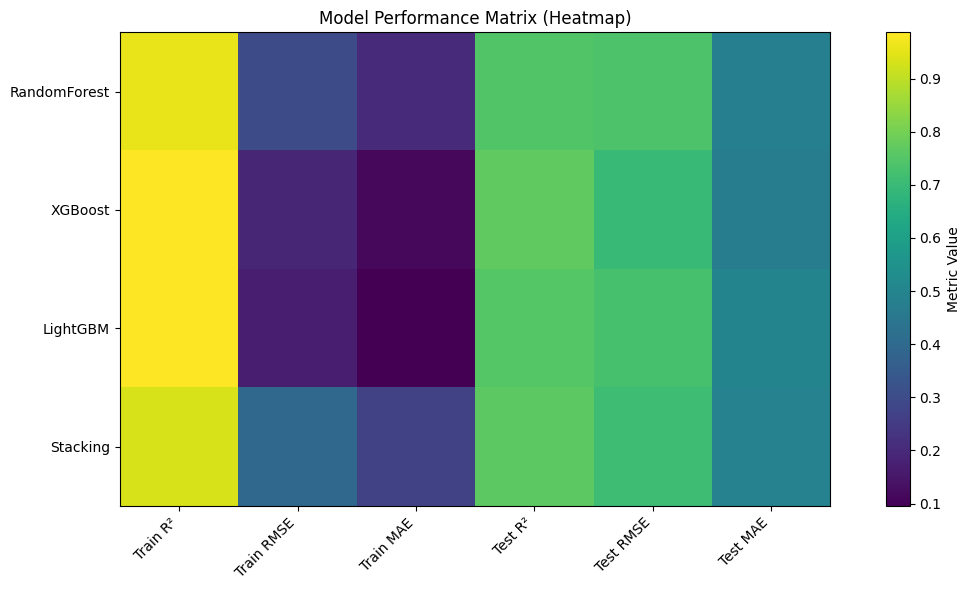

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# =======================
# PERFORMANCE METRIC DATA
# =======================
metrics = np.array([
    [0.9589, 0.3044, 0.2004, 0.7438, 0.7383, 0.4800],  # RandomForest
    [0.9837, 0.1919, 0.1147, 0.7689, 0.7012, 0.4749],  # XGBoost
    [0.9869, 0.1719, 0.0955, 0.7502, 0.7290, 0.4982],  # LightGBM
    [0.9317, 0.3922, 0.2710, 0.7638, 0.7089, 0.4918]   # Stacking
])

row_labels = ["RandomForest", "XGBoost", "LightGBM", "Stacking"]
col_labels = ["Train R²", "Train RMSE", "Train MAE", "Test R²", "Test RMSE", "Test MAE"]

# =======================
# HEATMAP PLOT
# =======================
plt.figure(figsize=(12, 6))
plt.imshow(metrics)

# Tick labels
plt.xticks(np.arange(len(col_labels)), col_labels, rotation=45, ha='right')
plt.yticks(np.arange(len(row_labels)), row_labels)

# Colorbar
plt.colorbar(label="Metric Value")

# Title
plt.title("Model Performance Matrix (Heatmap)")

plt.tight_layout()
plt.show()
